# Data Analysis
Data wrangling from LoopSeq sequences up to figure 3. <br>
Also includes stop codons' frequency estimate.

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import sys
import os
from os.path import join
import subprocess
import torch
from loop_pipeline import get_mutations, get_freqs
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

In [2]:
def set_plots_size_params(size):
    # Adapted from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
    bigger = size * 1.2
    slightly_bigger = size * 1.1
    plt.rc('font', size=size)                        # controls default text sizes
    plt.rc('axes', titlesize=bigger)                 # fontsize of the axes title
    plt.rc('axes', labelsize=bigger)        # fontsize of the x and y labels
    plt.rc('xtick', labelsize=bigger)                  # fontsize of the tick labels
    plt.rc('ytick', labelsize=bigger)                  # fontsize of the tick labels
    plt.rc('legend', fontsize=size)                  # legend fontsize
    plt.rc('figure', figsize=(0.75*size, size/2))    # size of figure
set_plots_size_params(20)

In [3]:
# the output of this pipeline is also available in zenodo under pipelines_results.tar.gz
def run_pipelines(data_path):
    data_dirs = [x for x in os.listdir(data_path) if x[-1]!='p']
    pipeline_path = 'loop_pipeline.py'
    reference_file = 'ms2_ref.fasta'
    for data_dir in data_dirs:
        fastq_name = os.listdir(join(data_path, data_dir)[0]
        fastq_path = join(data_path, data_dir, fastq_name)
        output_dir = 'data_pipeline_results'
        subprocess.run(f"python {pipeline_path} -i {fastq_path} -r {reference_file} -o {output_dir}".split(" "))
#run_pipelines(data_path)

In [4]:
def get_project_data(project_dir, file_name):
    """
    Naming of project sub-dirs MUST BE EXACTLY: p{passage_num}-{line_number/name}_{more_details}
    """
    data = pd.DataFrame()
    for d in os.listdir(project_dir):
        d_path = os.path.join(project_dir, d)
        if not os.path.isdir(d_path) or d[0] != 'p':
            continue
        df = pd.read_table(f'{d_path}/{file_name}.tsv')
        df['source'] = d
        df['passage'] = df.source.map(lambda s: int(s.split('-')[0][1:])).astype(int)
        if d == 'p0':
            df['line'] = None
        else:
            df['line'] = df.source.map(lambda s: s.split('-')[1].split("_")[0][-1]).astype(int)
            df['details'] = df.source.map(lambda s: s.split('-')[1].split("_")[1:])
            df['details'] = df.details.map(lambda s: "_".join(s))
        data = pd.concat([data, df])
    return data


In [5]:
def filter_reads_and_redo_freqs_and_mutations(project_path):
    reads = get_project_data(project_path, 'reads')
    reads = reads[reads.mut_num <= 12]  # filter out reads with too many mutations
    mutations = {}
    freqs = {}
    for source in reads.source.unique():
        df = reads[reads['source']==source]
        muts = get_mutations(df)
        mutations[source] = muts
        freqs[source] = get_freqs(muts, df)
        freqs[source]['source'] = source
        mutations[source]['source'] = source
    freqs = pd.concat(freqs.values())
    freqs['line'] = freqs.source.map(lambda s: s.split('-')[1].split("_")[0][-1]).astype(int)
    freqs['passage'] = freqs.source.map(lambda s: int(s.split('-')[0][1:])).astype(int)
    mutations = pd.concat(mutations.values())
    mutations['line'] = mutations.source.map(lambda s: s.split('-')[1].split("_")[0][-1]).astype(int)
    mutations['passage'] = mutations.source.map(lambda s: int(s.split('-')[0][1:])).astype(int)
    reads.to_csv('MOI01_long_reads_reads.tsv', sep='\t', index=False)
    mutations.to_csv('MOI01_long_reads_mutations.tsv', sep='\t', index=False)
    freqs.to_csv('MOI01_long_reads_freqs.tsv', sep='\t', index=False)

# project_path = 'pipelines_outoput_dir'
#filter_reads_and_redo_freqs_and_mutations(project_path)
reads = pd.read_table('MOI01_long_reads_reads.tsv')
mutations = pd.read_table('MOI01_long_reads_mutations.tsv')
freqs = pd.read_table('MOI01_long_reads_freqs.tsv').merge(
    mutations[['mut_name','source','type']].drop_duplicates(), on=['mut_name','source'])

In [6]:
mutypes = pd.read_csv('mutation_types_short.csv').set_index(['Pos','Base'])
non_syn_coding = mutypes[mutypes.mutation_type.notna()]
syns_list = mutypes[~mutypes.index.isin(non_syn_coding.index)].index  #syns in all reading frames!
freqs['read_base'] = freqs.transition.str[1]
freqs['ref_base'] = freqs.transition.str[0]
freqs['label'] = freqs['ref_base']+freqs['ref_pos'].astype(str)+freqs['read_base']
freqs['coverage'] = freqs['read_count'] / freqs['freq']
noindels = freqs[~freqs.transition.str.contains('-')].set_index(['ref_pos','read_base'])
coding_freqs = noindels[noindels.index.isin(mutypes.index)]
non_coding = noindels[~noindels.index.isin(mutypes.index)].reset_index()
syns = coding_freqs[coding_freqs.index.isin(syns_list)].reset_index()
non_syns = coding_freqs[~coding_freqs.index.isin(syns_list)].reset_index()

## create FITS input data

In [ ]:
def create_FITS_input(syns, fits_input='../FITS/FITS_input.tsv'):
    new_lines = []
    for line in syns.line.unique():
        line_df = syns[syns.line==line]
        for mut_name in line_df.mut_name.unique():
            mut_df = line_df[line_df.mut_name==mut_name]
            for pas in [3,7,10]:
                if mut_df[mut_df.passage==pas].empty:
                    new_lines.append({'mut_name': mut_name, 'line': line, 'passage': pas, 'freq': 0})
    syn_fits_with_zeros = pd.concat([syns,pd.DataFrame(new_lines)]).sort_values('passage')
    syn_fits_with_zeros[['line','passage','freq','mut_name']].to_csv(fits_input, sep='\t')
#create_FITS_input(syns)

## Table S1 data

In [7]:
reads.groupby(['line','passage']).mutations.count()

line  passage
1     3          1343
      7          4414
      10         1552
2     3          2347
      7          2604
      10         1230
3     3          2446
      7          1333
      10         3350
Name: mutations, dtype: int64

# Create haplotypes dataframe

In [8]:
def filter_noncoding_muts(muts):
    if muts is np.nan:
        return np.nan
    mut_list = muts.split('_')
    new_list = sorted([x for x in mut_list if int(x[:-2]) in mutypes.index.get_level_values(0)])
    return '_'.join(new_list)

reads['coding_mutations'] = reads['mutations'].map(filter_noncoding_muts)
reads['coding_mutations'] = reads.coding_mutations.fillna('')
reads['mutations'] = reads.mutations.fillna('')


In [9]:
def count_syn_muts(mutations):
    if mutations == 'WT' or mutations=='':
        return 0
    muts = mutations.split("_")
    return len([mut for mut in muts if (int(mut[:-2]),mut[-1]) in syns_list])

bens = ['1697AC', '1691TC', '1685CT', '1649TC']
bens_palette = [sns.color_palette('dark:purple')[3], 
                sns.light_palette("#70f", reverse=True)[1], 
                sns.light_palette("#70a", reverse=True)[2],
                sns.light_palette("#70a", reverse=True)[4]]
founders = ['224CT', '3299CT', '1554GA', '522GA']
founders_palette = [sns.color_palette("Oranges_r")[i] for i in [0,2]] + [sns.color_palette("light:orange_r")[i] for i in [0,3]]

def count_non_syn_bens(muts):
    non_syn_bens = ['1685CT', '1691TC', '1697AC']
    muts_list =  muts.split('_')
    bens = 0
    for mut in non_syn_bens:
        bens += muts_list.count(mut)
    return bens

color_map = {k:v for k,v in zip(bens,bens_palette)}
color_map.update({k:v for k,v in zip(founders,founders_palette)})
other_grey = sns.color_palette('Greys')[3]
def apply_color_map(muts):
    if muts=='WT':
        return 'white'
    for mut in muts.split('_'):
        if mut in bens:
            return color_map[mut]
        if mut in founders:
            return color_map[mut]
    return other_grey

def reads_to_haplos(reads, coding_only=True):
    if coding_only:
        muts_col = 'coding_mutations'
    else:
        muts_col = 'mutations'
    no_indels_reads = reads[~reads[muts_col].str.contains('-')].copy()
    haplos = no_indels_reads.groupby(['line','passage'])[muts_col].value_counts(normalize=True)
    haplos.name = 'freq'
    haplos = haplos.reset_index()
    haplos.loc[haplos[muts_col]=='', muts_col] = 'WT'
    haplos = haplos.sort_values('freq', ascending=False)
    haplos['mut_num'] = haplos[muts_col].map(lambda s: len(s.split("_")))
    haplos.loc[haplos[muts_col]=='WT', 'mut_num'] = 0
    haplos['syn_total'] = haplos[muts_col].map(count_syn_muts)
    haplos['non_syn_total'] = haplos['mut_num'] - haplos['syn_total']
    haplos['syn_ben'] = haplos[muts_col].map(lambda muts: muts.split('_').count('1649TC'))
    haplos['non_syn_ben'] = haplos[muts_col].map(count_non_syn_bens)
    haplos['color'] = haplos.coding_mutations.map(apply_color_map)
    return haplos

In [10]:
df = reads_to_haplos(reads, coding_only=True)

/sternadi/home/volume2/ita/miniconda/envs/sbi/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):


## aggregate loop data into summary statistics
(replicas A-C are denoted as lines 1-3)

In [1]:
def get_short_sumstat(df, passages=[3,7,10]):
    ret = list()
    for passage in passages:
        ret.append(sum(df['syn_total'] * df[passage]))
        ret.append(sum(df['non_syn_total'] * df[passage]))
    return torch.Tensor(ret)

def get_manual_stats(df, passages=[3,7,10]):
    max_muts = 11 # so 10 maximum muts
    new_index = [(x,y,z,w) for w in range(max_muts) for z in range(max_muts)
                 for y in range(max_muts) for x in range(max_muts) if x+y<max_muts and z<=x and w<=y]
    grouped = df.groupby(['syn_total', 'non_syn_total', 'syn_ben', 'non_syn_ben'])[passages].sum()
    return torch.Tensor(grouped.reindex(new_index).fillna(0).values.flatten())

def get_med_stats(df, passages=[3,7,10]):
    max_muts = 11 # so 10 maximum muts
    new_index = [(x,y) for y in range(max_muts) for x in range(max_muts) if x+y<max_muts]
    grouped = df.groupby(['syn_total', 'non_syn_total'])[passages].sum()
    return torch.Tensor(grouped.reindex(new_index).fillna(0).values.flatten())

def get_total_sumstat(df, passages=[3,7,10]):
    return torch.cat((get_short_sumstat(df, passages), get_med_stats(df, passages), get_manual_stats(df, passages)))

def wrangle_loop(data, line=1):
    index_cols = ['syn_total', 'non_syn_total', 'syn_ben', 'non_syn_ben']
    grouped_data = data[data.line==line].groupby(['passage']+index_cols).freq.sum().reset_index()
    pivoted = grouped_data.pivot_table(values='freq', index=index_cols, columns='passage').reset_index()
    return pivoted.fillna(0)

#for line in [1,2,3]:
#    torch.save(get_total_sumstat(wrangle_loop(df_coding, line=line)), f'line{line}_total_sumstat.pt')

# Figure 3A

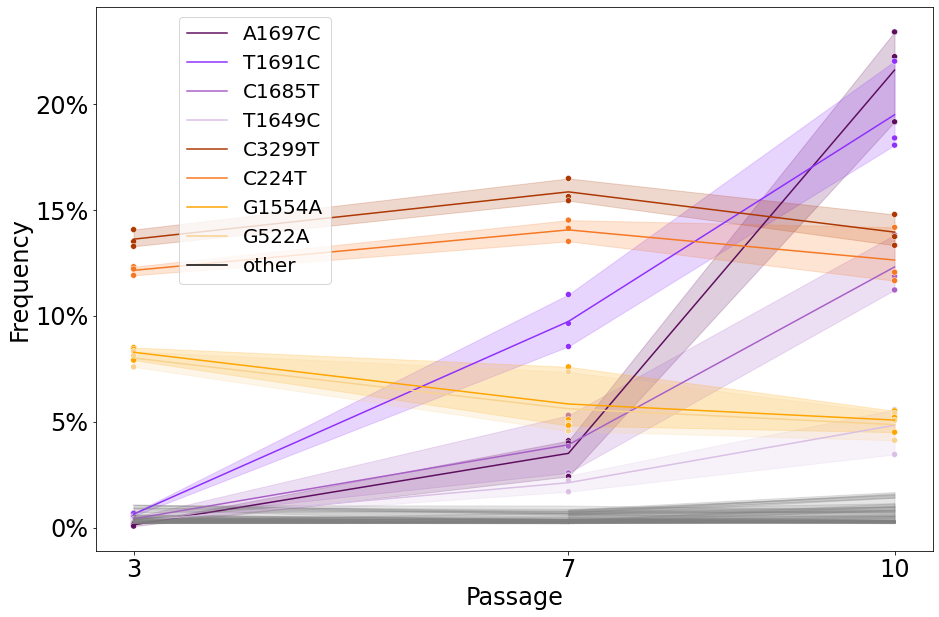

In [11]:
def plot_muts(data, pallete):
    sns.lineplot(data=data, x='passage', hue='label', y='freq', ci=100, palette=pallete)
    sns.scatterplot(data=data, x='passage', hue='label', y='freq', legend='', palette=pallete)

bens_palette = [sns.color_palette('dark:purple')[3], 
                sns.light_palette("#70f", reverse=True)[1], 
                sns.light_palette("#70a", reverse=True)[2],
                sns.light_palette("#70a", reverse=True)[4]]

bens = ['1697AC', '1691TC', '1685CT', '1649TC']
founders = ['224CT', '3299CT', '1554GA', '522GA']
founders_palette = sns.color_palette('Oranges_r')[:4]
founders_palette = [sns.color_palette("Oranges_r")[i] for i in [0,2]] + [sns.color_palette("light:orange_r")[i] for i in [0,3]]
def freqs_plot(coding_freqs):
    bens_df = coding_freqs[coding_freqs.mut_name.isin(bens)].reset_index().sort_values('freq', ascending=False)
    plot_muts(bens_df, bens_palette)
    founders_df = coding_freqs[coding_freqs.mut_name.isin(founders)].reset_index().sort_values('freq', ascending=False)
    plot_muts(founders_df, founders_palette)
    # plot other muts
    plot_data = coding_freqs[(~coding_freqs.mut_name.isin(bens+founders)) & (coding_freqs.freq>0.002)].reset_index()
    for mut_name in plot_data.mut_name.unique():
        tmp = plot_data[plot_data.mut_name==mut_name]
        sns.lineplot(data=tmp, x='passage', y='freq', ci=100, color='gray', alpha=0.3)
    # fix legend
    handles, labels = plt.gca().get_legend_handles_labels()
    line = plt.Line2D([0], [0], label='other', color='k')
    handles.extend([line])
    plt.legend(handles=handles, loc=(0.1,0.49))
    plt.ylabel('Frequency')
    plt.yticks(ticks=[0,0.05, 0.1, 0.15,0.2], labels=['0%', '5%', '10%', '15%', '20%'])
    plt.xticks([3,7,10])
    plt.xlabel('Passage')
    return handles, labels
h, l  = freqs_plot(coding_freqs)

# Fig 3B

### calc existing mutations pairs

In [12]:
def calc_observed_pairs(df, coding_freqs):
    comuts = list()
    df.apply(lambda row: [comuts.append({'comut':x, 'freq': row.freq, 'line': row.line, 'passage': row.passage}) for x in combinations(row.coding_mutations.split('_'),2)], axis=1)
    comuts = pd.DataFrame(comuts)
    common_muts = coding_freqs[coding_freqs.freq>0.01].mut_name.unique()
    for comut in combinations(common_muts,2):
        for line in range(1,4):
            for passage in [3,7,10]:
                tmp = comuts[(comuts.line==line) & (comuts.passage==passage)]
                if (comut in tmp.comut.unique()) or ((comut[1], comut[0]) in tmp.comut.unique()) :
                    continue
                comuts = comuts.append({'comut':comut, 'freq': 0, 'line': line, 'passage': passage}, ignore_index=True)
    comuts = pd.DataFrame(comuts)
    comuts = comuts.groupby(['line','passage','comut']).freq.sum().reset_index()
    return comuts

def calc_expected_pairs(comuts, coding_freqs):
    exp_comuts = list()
    for line in [1,2,3]:
        print('Calculating expected pairs for line', line)
        for passage in [3,7,10]:
            tmp = coding_freqs[(coding_freqs.line==line) & (coding_freqs.passage==passage)]
            for cm in comuts.comut.unique():
                if (tmp.loc[tmp['mut_name']==cm[0], 'freq'].empty) or (tmp.loc[tmp['mut_name']==cm[1], 'freq'].empty):
                    freq = 0
                else:
                    freq = tmp.loc[tmp['mut_name']==cm[0], 'freq'].values[0] * tmp.loc[tmp['mut_name']==cm[1], 'freq'].values[0]
                exp_comuts.append({'comut': cm, 'line': line, 'passage': passage, 'exp_freq': freq})

    df_comuts = pd.DataFrame(exp_comuts)
    com_df = comuts.merge(df_comuts, how='left').fillna(0)
    return com_df

def create_mut_pairs_plot_data(df, coding_freqs):
    comuts = calc_observed_pairs(df, coding_freqs)
    com_df = calc_expected_pairs(comuts, coding_freqs)
    plot_data = com_df[(com_df.passage==10)].sort_values('exp_freq', ascending=False) 
    return plot_data


### calc expected mutation pairs

In [13]:
founder_pairs = [('224CT', '3299CT'), ('1554GA','522GA')]

In [14]:
plot_data = create_mut_pairs_plot_data(df, coding_freqs)

/tmp/ipykernel_17838/3660857690.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (comut in tmp.comut.unique()) or ((comut[1], comut[0]) in tmp.comut.unique()) :


Calculating expected pairs for line 1
Calculating expected pairs for line 2
Calculating expected pairs for line 3


In [15]:
def plot_mutation_pairs(plot_data):
    no_founders = plot_data[~plot_data.comut.isin(founder_pairs)]
    color_dict = {k: v for k,v in zip(bens,bens_palette)}
    color_dict.update({k: v for k,v in zip(founders, founders_palette)})
    #sns.scatterplot(data=plot_data, x='exp_freq', y='freq', color='gray', s=90)
    #color_data = plot_data[(plot_data.comut.isin(interesting_comuts))].sort_values(
    #    'freq', ascending=True).rename(columns={'comut': 'Mutation Pair'})
    color_data = no_founders.rename(columns={'comut': 'Mutation Pair'})
    color_data['label'] = color_data['Mutation Pair'].map(
        lambda x: x[0][-2]+x[0][:-2]+x[0][-1]+'_'+x[1][-2]+x[1][:-2]+x[1][-1])
    color_data['l_color'] = color_data['Mutation Pair'].map(
        lambda x: color_dict[x[0]] if x[0] in color_dict.keys() else 'grey')
    color_data['r_color'] = color_data['Mutation Pair'].map(
        lambda x: color_dict[x[1]] if x[1] in color_dict.keys() else 'grey')
    prev_pairs = list()
    for i, row in color_data.iterrows():
        plt.plot(row['freq'], row['exp_freq'], c=row['l_color'], 
                 markerfacecoloralt=row['r_color'],
                 marker='.', linestyle='', markeredgecolor='None', 
                 label=row['label'] if row['Mutation Pair'] not in prev_pairs else '_nolegend',
                 markersize=25, fillstyle='left', markeredgewidth=0)
        prev_pairs.append(row['Mutation Pair'])
    plt.plot([0,0.06],[0,0.06])
    plt.ylabel(r'Expected Frequency - F(X)$\cdot$F(Y)')
    plt.xlabel('Observed Frequency - F(X,Y)')
    #plt.title('Pairs of Mutations Across All Replicas')
    labels = [x[-2]+x[:-2]+x[-1] for x in color_dict.keys()]
    labels.append('other')
    handles = [plt.Line2D([], [], color=color, linestyle='', marker='.', markersize=15) for color in color_dict.values()]
    handles.append(plt.Line2D([], [], color='grey', linestyle='', marker='.', markersize=15))
    plt.legend(handles=handles, labels=labels)

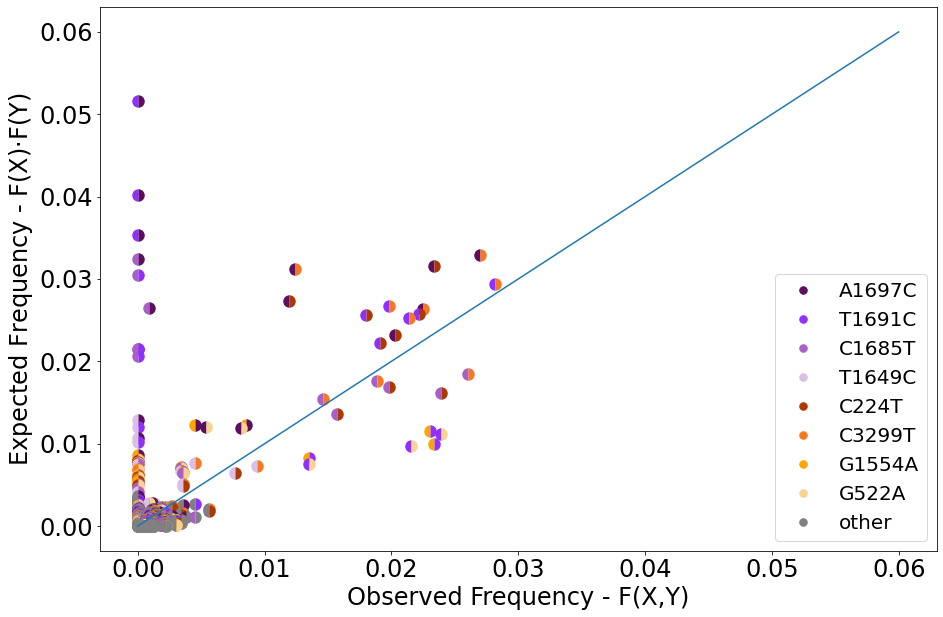

In [16]:
plot_mutation_pairs(plot_data)

# Fig 3D

In [17]:
line_dict = {1:'A\n', 3:'C\n'}
passage_dict = {3: '', 7: ' ', 10: '   '}
color_dict = {k: v for k,v in zip(bens,bens_palette)}
color_dict.update({k: v for k,v in zip(founders, founders_palette)})

color_codes = {"white": 0, (0.6768627450980392, 0.22089965397923875, 0.010749711649365628): 1, #orange1
               (0.9648442906574395, 0.47100346020761247, 0.14197616301422528): 2, #orange2
               (0.8782929642445213, 0.31990772779700116, 0.024405997693194927): 3, #orange3
               (0.9921568627450981, 0.6280507497116494, 0.34226835832372166): 4, #orange4
               (0.3405767012687428, 0.1742560553633218, 0.5709342560553633): 5, # purple1
               (0.440722798923491, 0.36772010765090346, 0.6653902345251825): 6, #purple2
               (0.5513264129181085, 0.537916186082276, 0.7524490580545944): 7, #purple3
               (0.9921568627450981, 0.6280507497116494, 0.34226835832372166): 8, #blue
               'grey': 9}


def apply_x(line, passage):
    if line==2:
        return f"B\n{passage}"
    else:
        return line_dict[line]+passage_dict[passage]

def create_muts_list(bars_data):
    muts = list()
    for passage in [3,7,10]:
        muts.append(bars_data[bars_data.passage==passage].sort_values('freq').coding_mutations.unique())
    muts_list = list(np.concatenate(muts))[::-1]
    unique_muts = [ v for (i,v) in enumerate(muts_list) if v not in muts_list[0:i] ][::-1]
    return unique_muts

def create_bars_data(df):
    bars_data = df.copy()
    bars_data['x'] = bars_data.apply(lambda row: apply_x(row['line'], row['passage']), axis=1)
    bars_data['color_code'] = bars_data.color.map(color_codes)
    muts_list = create_muts_list(bars_data)
    return bars_data.sort_values(['passage','line']), muts_list

def bar_legend(color_dict, wt_width, rare_width, hatches):
    label_color_dict = {k[-2]+k[:-2]+k[-1]: v for k,v in color_dict.items()}
    handles = []
    for label, color in label_color_dict.items():
        handles.append(mpatches.Patch(color=color, label=label))
    handles.append(mpatches.Patch(facecolor=other_grey, label='other'))
    handles.append(mpatches.Patch(facecolor='white', label='WT', linewidth=wt_width, edgecolor='black'))
    for i, hatch in enumerate(hatches):
        label = f'{i+1} mutation'
        if i>0:
            label += 's'
        handles.append(mpatches.Patch(facecolor='white', label=label, hatch=hatch))
    handles.append(mpatches.Patch(facecolor='white', label='rare genotypes', linewidth=rare_width, edgecolor='black', linestyle='--'))
    plt.legend(handles=handles, title='genoypes containing', bbox_to_anchor=(1,1.02))

def _alternate_colors(color, prev_color, color_diff):
    if color==prev_color:
        shifted_color = tuple()
        for c in color:
            if c+color_diff>1:
                shifted_color += (c-color_diff,)
            else:
                shifted_color += (c+color_diff,)
        return shifted_color
    else:
        return color

def plot_bars(df, color_diff=0.05, wt_width=0.3, line_width_factor=0, rare_width=1.5, 
               rare_cutoff=0.005, alternate_colors=True, hatches=[]):
    bars_data, unique_muts = create_bars_data(df)
    bottom = np.zeros(9)
    prev_color = None
    col_debug = list()
    for passage in bars_data.passage.unique():
        for line in bars_data.line.unique():
            bottom = 0
            dataset = bars_data[(bars_data.line==line) & (bars_data.passage==passage)]
            unrares = dataset[dataset.freq>=rare_cutoff].sort_values(['freq', 'mut_num'], ascending=[True, False])
            rares = dataset[dataset.freq<rare_cutoff].sort_values(['mut_num'], ascending=[False])
            dataset = pd.concat([rares,unrares])
            linewidth = line_width_factor * dataset.freq.min()
            muts = dataset.coding_mutations.unique()
            muts = np.delete(muts, np.where(muts == 'WT'), axis=0)
            muts = np.append(muts, 'WT')
            for mut in muts:
                hatch = None
                tmp = dataset[dataset.coding_mutations==mut].sort_values('passage')
                color = tmp.color.values[0]
                if alternate_colors:
                    color = _alternate_colors(color, prev_color, color_diff)
                tmp = tmp.sort_values(['passage','line'])                
                if color=='white':
                    linewidth = wt_width
                num_of_muts = tmp.mut_num.values[0]
                if (len(hatches) >= num_of_muts) & (num_of_muts != 0):
                    hatch = hatches[num_of_muts-1]
                plt.bar(x=tmp['x'], height=tmp.freq.values[0], bottom=bottom, color=color, width=0.6,
                    linewidth=linewidth, edgecolor='black', hatch=hatch)
                bottom += tmp.freq.values[0]
                prev_color = color
            # mark rare
            rare = dataset[dataset.freq<rare_cutoff].freq.sum()
            g = plt.bar(x=dataset['x'].values[0], height=rare, bottom=0, width=0.75,
                linewidth=rare_width, edgecolor='black', linestyle='--', fill=False)
    #plt.ylim([0,1.05])
    bar_legend(color_dict, wt_width, rare_width, hatches)
    plt.xlabel('Dataset')
    plt.ylabel('Frequency')
    #plt.title('Genotype Diversity Across Empirical Data')

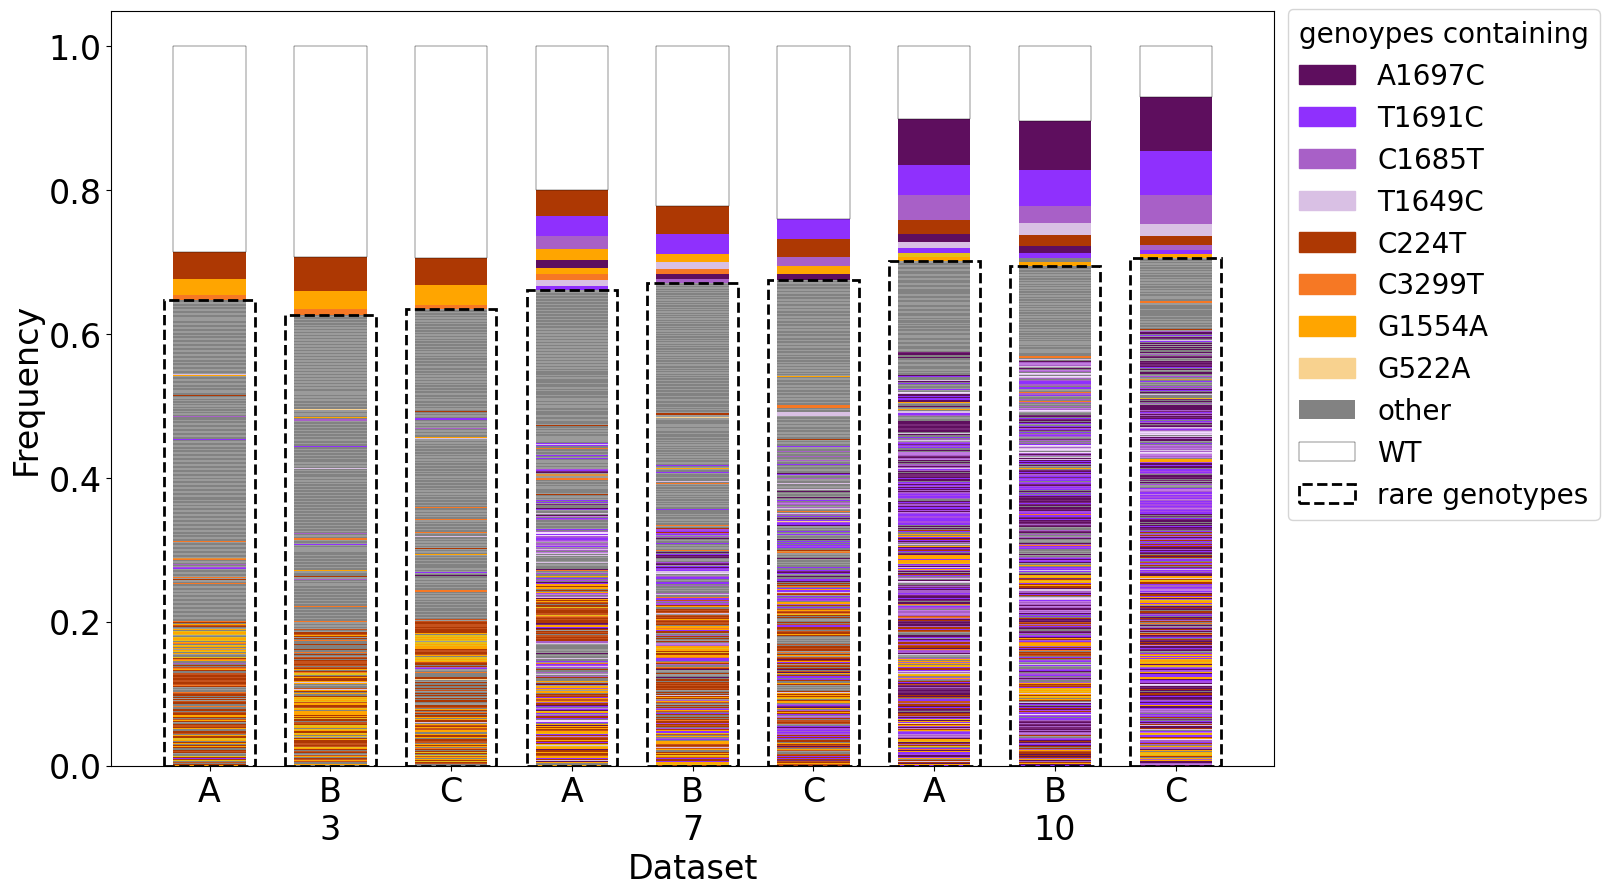

In [18]:
plt.figure(dpi=100)
plot_bars(df, color_diff=0.1, wt_width=0.3, rare_width=2, line_width_factor=0, alternate_colors=True)

# Fig. S5

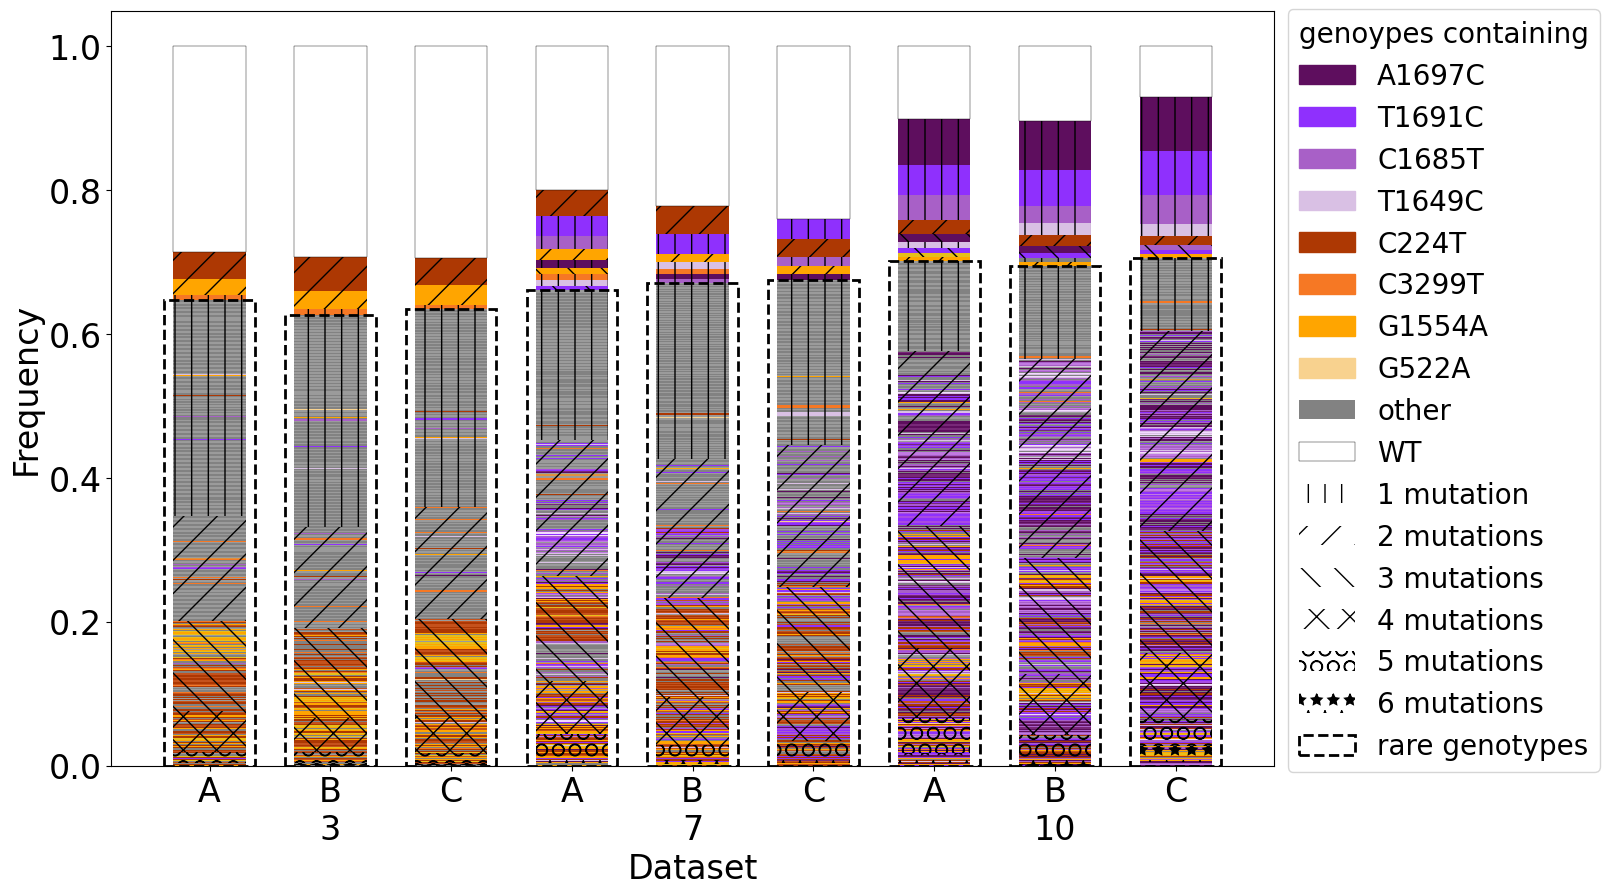

In [19]:
plt.figure(dpi=100)
plot_bars(df, color_diff=0.1, wt_width=0.3, rare_width=2, line_width_factor=0, alternate_colors=True, 
                  hatches=['|','/','\\','x', 'O', '*'])

# Estimating stop codons' frequency

In [20]:
mutypes = pd.read_csv('mutation_types_short.csv')[['Pos', 'Ref', 'Base', 'protein', 'mutation_type']]
mutypes = mutypes.rename(columns={"Pos":"ref_pos","Ref":"ref_base","Base":"read_base"})
mutypes['ref_pos'] = mutypes.ref_pos.astype(float)
coding_region = mutypes.ref_pos.unique()
# assign protein mutations (non-codin / ref / syn / non-syn / frameshift)
freqs = pd.read_table('MOI01_long_reads_freqs.tsv')
freqs['ref_base'] = freqs.transition.str[0]
freqs['read_base'] = freqs.transition.str[1]
freqs = pd.merge(freqs,mutypes, how = 'outer', on = ['ref_pos','ref_base','read_base'])
freqs['prot_mut'] = 'non-coding'
freqs.loc[freqs['ref_base'] == freqs['read_base'], ['prot_mut']] = 'ref'         
freqs.loc[freqs['mutation_type'] == '[]', 'prot_mut'] = 'synonymous'
freqs.loc[((freqs['mutation_type'] != '[]') & ~(freqs['mutation_type'].isna())), 'prot_mut'] = 'non-synonymous'
freqs.loc[freqs['mutation_type'].str[-1]=="*", 'prot_mut'] = 'stop'
freqs.loc[((round(freqs['ref_pos']).isin(coding_region)) & (freqs['read_base'] == '-')), 'prot_mut'] = 'frameshift' # Deletion
freqs.loc[((round(freqs['ref_pos']).isin(coding_region)) & (freqs['ref_base'] == '-')), 'prot_mut'] = 'frameshift' # insertion

In [21]:
mutypes['mutation_type'] = mutypes['mutation_type'].fillna('syn')
mutypes['stop'] = mutypes.mutation_type.map(lambda t: True if t[-1]=='*' else False)
stop_poses = freqs[freqs.prot_mut=='stop'].ref_pos.unique()
stops_data = mutypes[mutypes.ref_pos.isin(stop_poses)]
stops_per_pos = stops_data.groupby(['ref_pos','read_base']).stop.apply(lambda s: s.any()).groupby('ref_pos').sum()

In [22]:
stops_df = freqs[(freqs.prot_mut=='stop')].copy()
stops_df['stops_per_pos'] = stops_df.ref_pos.map(stops_per_pos)

<AxesSubplot:>

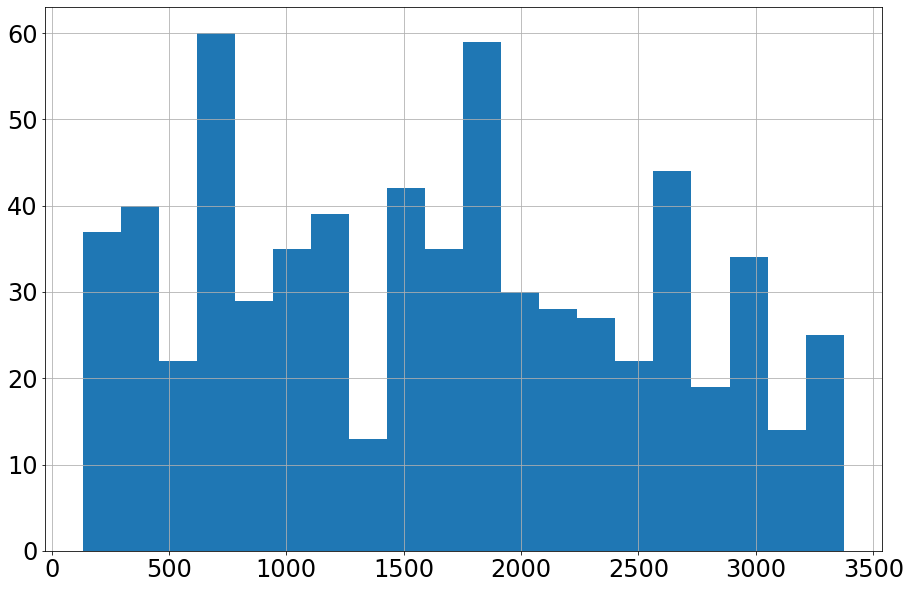

In [23]:
# stop codons are well distributed
stops_df.ref_pos.hist(bins=20)

In [24]:
number_sequenced_positions = 3564
stop_codon_frequeny = number_sequenced_positions * stops_df.read_count.sum() / (len(reads) * sum(stops_per_pos))
stop_codon_frequeny

0.1867569104970218